In [4]:
import os, urllib.request, numpy as np, matplotlib.pyplot as plt
import librosa, soundfile as sf
from sklearn.decomposition import FastICA

# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Toggle: download sample audio automatically (True) or use local files (False)
USE_DOWNLOAD = True

# If using local files, put your paths here (WAV/MP3 supported by librosa):
LOCAL_FILES = [
    "audio/speech.wav",  # e.g., your speech file
    "audio/music.wav",   # e.g., your music file
]

# Download targets (2 short sounds; “e.g.” can be any two sources)
AUDIO_DIR = "audio"
os.makedirs(AUDIO_DIR, exist_ok=True)
URLS = [
    "https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.wav",  # singing/music sample
    "https://raw.githubusercontent.com/pdx-cs-sound/wavs/master/voice.wav",             # short voice recording
]


TARGET_SR = 16000       # common sample rate
MAX_SECONDS = 10.0      # trim to same length for speed/clarity
PLOT_SECONDS = 3.0      # shorter window for plots (readable)


In [5]:
def download_if_needed(url, out_path):
    if not os.path.exists(out_path):
        print(f"Downloading {url} -> {out_path}")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"Found cached: {out_path}")

def load_mono(path, sr=TARGET_SR, max_seconds=None):
    y, sr = librosa.load(path, sr=sr, mono=True)
    if max_seconds is not None:
        y = y[: int(max_seconds * sr)]
    return y, sr

def trim_to_shortest(arrays):
    m = min(map(len, arrays))
    return [a[:m] for a in arrays]

def mix_sources(S, rng, det_min=0.3):
    """
    S: list or array of shape [n_src, T]
    Returns: A (2x2), X (2xT)
    """
    assert len(S) == 2, "This demo expects exactly 2 sources."
    S = np.asarray(S)
    # Random well-conditioned 2x2 mixing
    while True:
        A = rng.normal(size=(2,2))
        if abs(np.linalg.det(A)) > det_min:
            break
    X = A @ S
    return A, X

def fastica_unmix(X):
    """
    X: [2, T] mixtures -> returns S_hat [2, T], W (unmixing)
    sklearn FastICA expects shape [T, n_features]
    """
    X_T = X.T  # [T, 2]
    ica = FastICA(n_components=2, whiten='unit-variance', random_state=SEED, max_iter=2000)
    S_hat_T = ica.fit_transform(X_T)  # [T, 2]
    S_hat = S_hat_T.T
    W = ica.components_              # [2,2] (unmixing)
    return S_hat, W

def corr_abs(a, b):
    """Absolute Pearson correlation between two 1D arrays."""
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return abs(np.dot(a, b) / denom)

def best_permutation(S_true, S_hat):
    """
    Match separated components to true sources (2×T each)
    Returns: S_hat_aligned, correlations (length 2), perm, signs
    """
    S_true = np.asarray(S_true); S_hat = np.asarray(S_hat)
    c00 = corr_abs(S_true[0], S_hat[0]); c01 = corr_abs(S_true[0], S_hat[1])
    c10 = corr_abs(S_true[1], S_hat[0]); c11 = corr_abs(S_true[1], S_hat[1])
    # two permutations: [0<-0, 1<-1] or [0<-1, 1<-0]
    sum_p0 = c00 + c11
    sum_p1 = c01 + c10
    if sum_p0 >= sum_p1:
        # perm [0,1]
        perm = [0,1]
        corrs = [c00, c11]
    else:
        # perm [1,0]
        perm = [1,0]
        corrs = [c01, c10]
    # Fix signs so correlation is positive
    S_aligned = np.zeros_like(S_hat)
    signs = []
    for i, j in enumerate(perm):
        s = 1.0
        if np.corrcoef(S_true[i], S_hat[j])[0,1] < 0:
            s = -1.0
        S_aligned[i] = s * S_hat[j]
        signs.append(s)
    return S_aligned, corrs, perm, signs

def plot_waveforms(rows, titles, sr, seconds=None, figsize=(12, 6)):
    """
    rows: list of 1D arrays (signals) to plot vertically
    titles: list of titles (same length)
    """
    if seconds is not None:
        rows = [r[: int(seconds * sr)] for r in rows]
    t_axes = [np.arange(len(r)) / sr for r in rows]
    plt.figure(figsize=figsize)
    for i, (t, r) in enumerate(zip(t_axes, rows), start=1):
        ax = plt.subplot(len(rows), 1, i)
        ax.plot(t, r, linewidth=0.8)
        ax.set_xlim(0, t[-1] if len(t) else 1)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.set_title(titles[i-1])
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [6]:
paths = []
if USE_DOWNLOAD:
    for idx, url in enumerate(URLS):
        out = os.path.join(AUDIO_DIR, f"src_{idx+1}.wav")
        download_if_needed(url, out)
        paths.append(out)
else:
    assert len(LOCAL_FILES) == 2, "Provide two paths in LOCAL_FILES."
    paths = LOCAL_FILES

# Load, resample, mono, trim to common length
sigs, sr = [], None
for p in paths:
    y, sr = load_mono(p, sr=TARGET_SR, max_seconds=MAX_SECONDS)
    # Normalize each source to unit std (eases ICA scaling/sign)
    y = y / (np.std(y) + 1e-12)
    sigs.append(y)

sigs = trim_to_shortest(sigs)
S = np.stack(sigs, axis=0)  # [2, T]
T = S.shape[1]
print("Loaded sources:", paths)
print("Shape S:", S.shape, "Sample Rate:", sr)


Loaded sources: ['audio\\src_1.wav', 'audio\\src_2.wav']
Shape S: (2, 79190) Sample Rate: 16000


Mixing matrix A:
 [[ 0.30471708 -1.03998411]
 [ 0.7504512   0.94056472]]
det(A) = 1.0670634498466751
Mixtures X shape: (2, 79190)


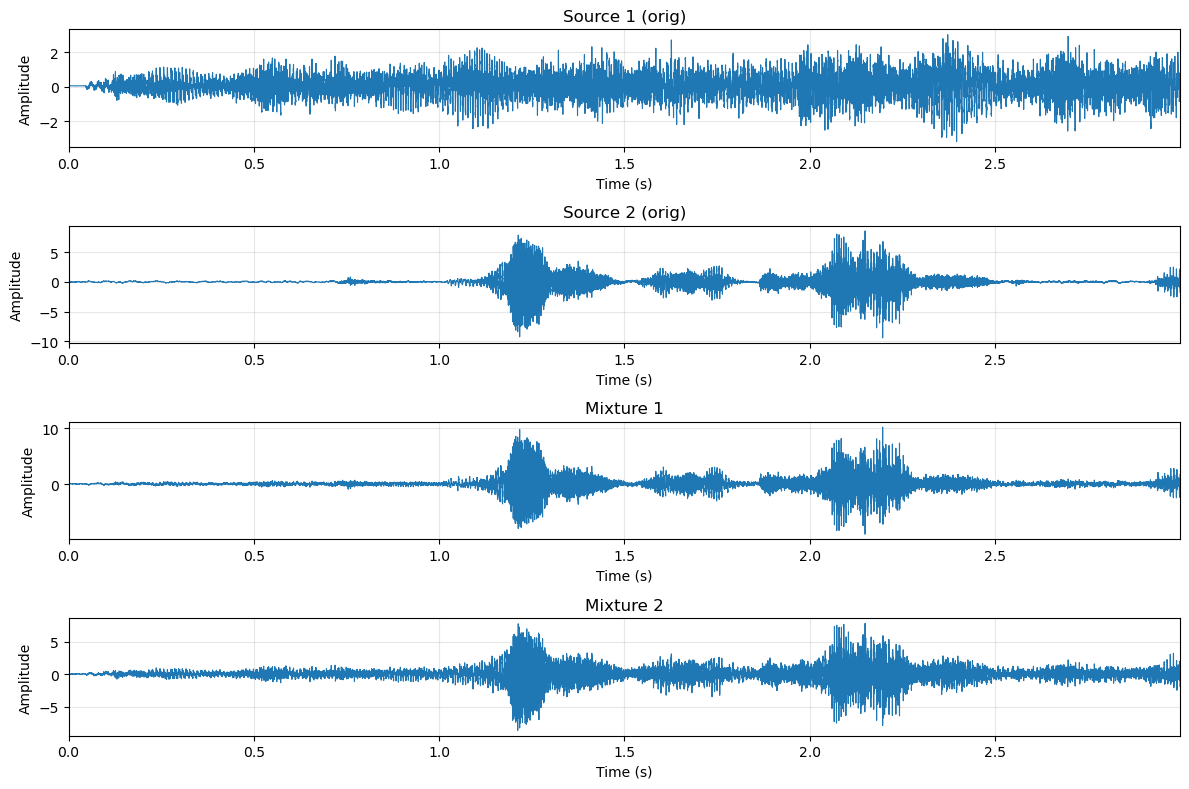

In [7]:
A, X = mix_sources(S, rng)
print("Mixing matrix A:\n", A)
print("det(A) =", np.linalg.det(A))
print("Mixtures X shape:", X.shape)

# Save mixes for listening
os.makedirs("outputs", exist_ok=True)
sf.write("outputs/mix1.wav", X[0], sr)
sf.write("outputs/mix2.wav", X[1], sr)

# Plot (short window)
plot_waveforms(
    [S[0], S[1], X[0], X[1]],
    ["Source 1 (orig)", "Source 2 (orig)", "Mixture 1", "Mixture 2"],
    sr, seconds=PLOT_SECONDS, figsize=(12,8)
)


Unmixing W (approx A^{-1} up to scale/perm/sign):
 [[-0.71348447  0.27435546]
 [-1.10196182 -1.21624548]]
Best permutation: [1, 0], signs: [-1.0, 1.0]
Abs correlations (matched): 1.0000, 1.0000


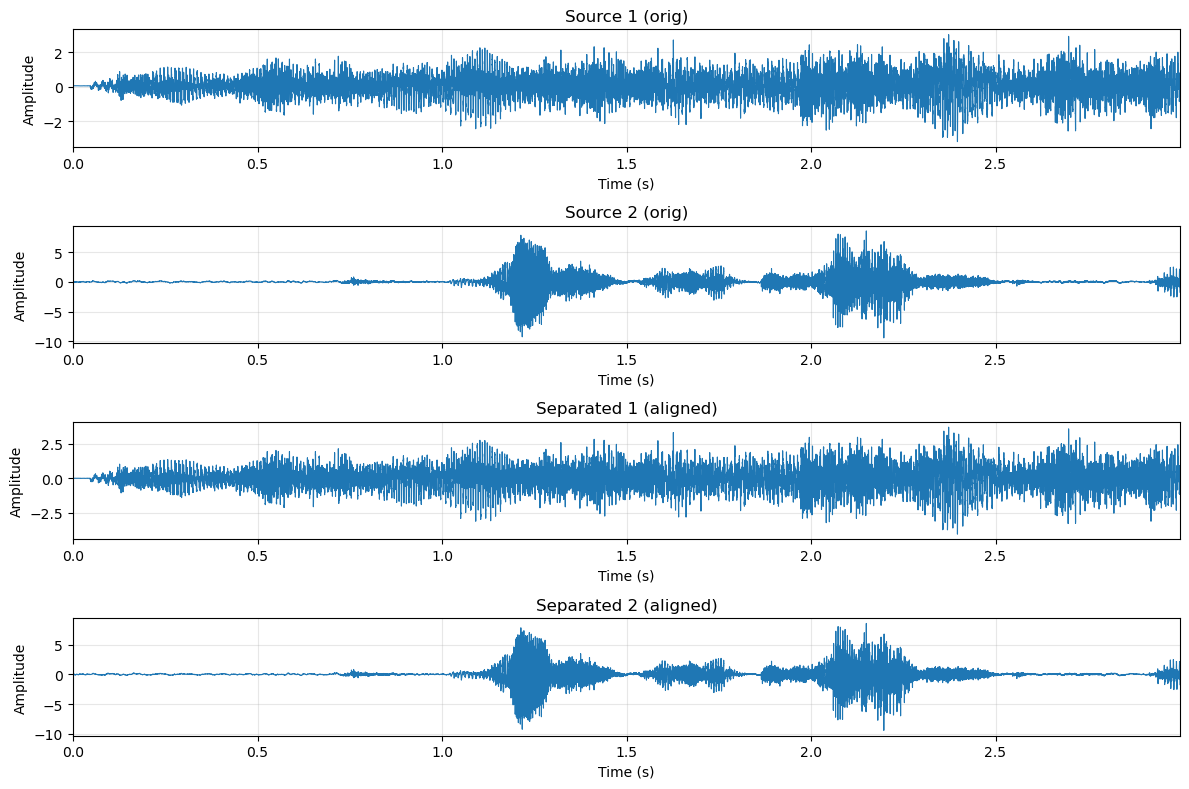

In [8]:
S_hat, W = fastica_unmix(X)
print("Unmixing W (approx A^{-1} up to scale/perm/sign):\n", W)

# Match order & sign to the original sources for evaluation
S_rec, corrs, perm, signs = best_permutation(S, S_hat)
print(f"Best permutation: {perm}, signs: {signs}")
print(f"Abs correlations (matched): {corrs[0]:.4f}, {corrs[1]:.4f}")

# Save recovered signals
sf.write("outputs/sep1.wav", S_rec[0], sr)
sf.write("outputs/sep2.wav", S_rec[1], sr)

# Plot (short window)
plot_waveforms(
    [S[0], S[1], S_rec[0], S_rec[1]],
    ["Source 1 (orig)", "Source 2 (orig)", "Separated 1 (aligned)", "Separated 2 (aligned)"],
    sr, seconds=PLOT_SECONDS, figsize=(12,8)
)


In [9]:
# Full 2x2 absolute correlation matrix between (true) and (estimated raw)
C = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        C[i,j] = corr_abs(S[i], S_hat[j])

print("Abs correlation matrix between true sources (rows) and estimated (cols):")
print(np.round(C, 4))

print("\nMatched (after perm/sign) absolute correlations:")
print(f"S1 ↔ Sep{perm[0]+1}: {corrs[0]:.4f}")
print(f"S2 ↔ Sep{perm[1]+1}: {corrs[1]:.4f}")
print("\nWAVs saved in ./outputs (mix1, mix2, sep1, sep2).")


Abs correlation matrix between true sources (rows) and estimated (cols):
[[0.0021 1.    ]
 [1.     0.0092]]

Matched (after perm/sign) absolute correlations:
S1 ↔ Sep2: 1.0000
S2 ↔ Sep1: 1.0000

WAVs saved in ./outputs (mix1, mix2, sep1, sep2).
